In [2]:
## Cell 1: Import Libraries and Setup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set up display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
## Cell 2: Get Stock Data and Explore
def get_stocks_data(symbols, start_date, end_date):
    """Get data for multiple stocks"""
    if isinstance(symbols, str):
        symbols = [symbols]  # Convert single string to list
    
    print(f"Getting data for {symbols} from {start_date} to {end_date}...")
    data = yf.download(symbols, start=start_date, end=end_date)
    print(f"Got {len(data)} days of data for {len(symbols)} stocks")
    
    # Flatten if only one stock to keep it simple
    if len(symbols) == 1:
        data = data.droplevel(1, axis=1)
    
    return data

# Let's get Apple stock data for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
symbol = 'AAPL'

data = get_stocks_data(symbol, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

# Explore the data
print("\nFirst 5 rows of data:")
print(data.head())

print(f"\nStock price range:")
print(f"Lowest: ${data['Close'].min():.2f}")
print(f"Highest: ${data['Close'].max():.2f}")
print(f"Average: ${data['Close'].mean():.2f}")

C:\Users\lippm\AppData\Local\Temp\ipykernel_21176\2014404218.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Getting data for ['AAPL'] from 2024-08-09 to 2025-08-09...
Got 250 days of data for 1 stocks

First 5 rows of data:
Price            Close        High         Low        Open    Volume
Date                                                                
2024-08-09  215.233429  215.770909  210.983301  211.112701  42201600
2024-08-12  216.768021  218.741081  214.844788  215.313143  38028100
2024-08-13  220.494949  221.112773  218.242856  218.242856  44155300
2024-08-14  220.943344  222.248753  218.930416  219.797379  41960600
2024-08-15  223.932861  224.560659  221.979720  223.813287  46414000

Stock price range:
Lowest: $172.19
Highest: $258.40
Average: $221.57


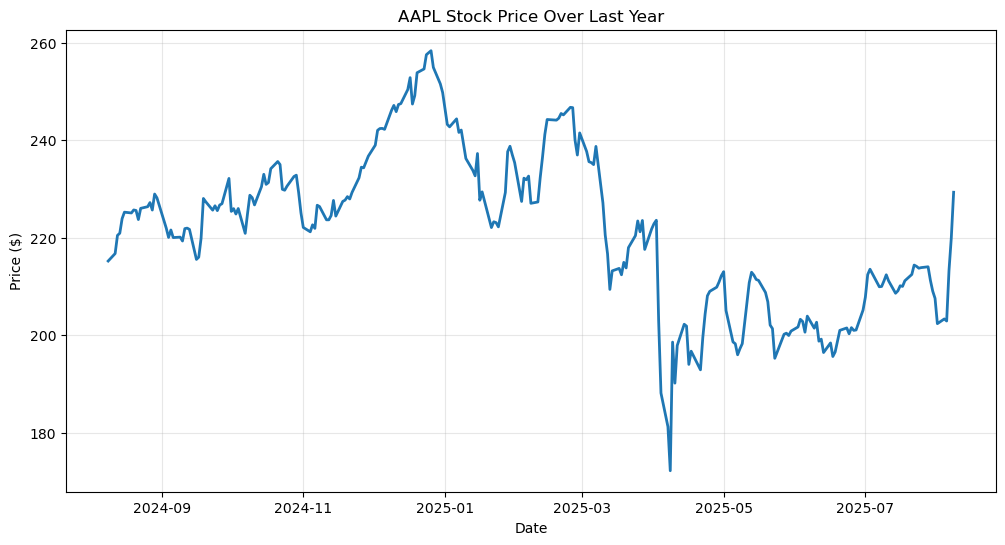

We'll be testing strategies on this 250-day period


In [9]:
## Cell 3: Plot Stock Price to See What We're Working With
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], linewidth=2)
plt.title(f'{symbol} Stock Price Over Last Year')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"We'll be testing strategies on this {len(data)}-day period")


In [ ]:
## Cell 4: Define and Test Dip Buying Strategy
